In [3]:
import pandas as pd

df_flush = pd.read_pickle('beluga_data_withflush.pkl')
df_noflush = pd.read_pickle('beluga_data_withoutflush.pkl')

In [34]:
def feature_scatter(df, zoom=False, fn="figure.pdf"):
    import numpy as np
    import matplotlib.pyplot as plt
    import matplotlib.patches as mpatches
    import matplotlib.lines as mlines
    from matplotlib.colors import to_rgba

    df = df[df["busy_writers"] == 0]
    
    identity = None
    
    if len(df) > 0:
        identity = range(int(max(df["makespan"])) + 1)

    colours = { "afni":"#003f5c", "spm": "#bc5090", "fsl": "#ffa600" }
    markers = { "preventAD":"^", "ds001545": "X", "HCP": "o" }
    edge = "black"
    line = { 1: 1.5, 8: 0, 16: 2}
    size = { 1: 12, 8: 8*12, 16: 8*12}
    alpha = 0.5
    
    if identity is not None:
        plt.plot(identity, identity, color="black", alpha=0.5, zorder=-1)
    
    if zoom:
        plt.text(1100, 1250, "y=x", rotation=34.5)
    else:
        plt.text(10000, 10500, "y=x", rotation=34)
    for pipeline in ["afni", "spm", "fsl"]:
        for dataset in ["preventAD", "ds001545", "HCP"]:

            for n_images in [1, 8, 16]:
                data = (df[(df["pipeline"] == pipeline)
                           & (df["dataset"] == dataset)
                           & (df["n_images"] == n_images)])
                
                plt.scatter(data["makespan"],
                    data["sea_makespan"],
                    c=[to_rgba(colours[pipeline], alpha=alpha)],
                    s=size[n_images],
                    marker=markers[dataset],
                    edgecolors=colours[pipeline],
                    linewidth=line[n_images],
                    label=f"{pipeline} - {dataset} - {n_images}")
    
    afni_patch = mpatches.Patch(color=colours["afni"], label='AFNI', alpha=alpha)
    spm_patch = mpatches.Patch(color=colours["spm"], label='SPM', alpha=alpha)
    fsl_patch = mpatches.Patch(color=colours["fsl"], label='FSL', alpha=alpha)
        
    preventad_line = mlines.Line2D([], [], color='black',
                                   marker=markers["preventAD"],
                                   markersize=10, linestyle='None', alpha=alpha,
                                   label='preventAD')
    ds001545_line = mlines.Line2D([], [], color='black', marker=markers["ds001545"],
                                   markersize=10, linestyle='None', alpha=alpha,
                                   label='ds001545')
    hcp_line = mlines.Line2D([], [], color='black', marker=markers["HCP"],
                                   markersize=10, linestyle='None', alpha=alpha,
                                   label='HCP')
    
    im1_line = mlines.Line2D([], [],
                             color=to_rgba('black', alpha=alpha),
                             marker=markers["HCP"],
                             markersize=4,
                             markeredgewidth=line[1],
                             linestyle='None',
                             label='1 process')
    im8_line = mlines.Line2D([], [],
                             color=to_rgba('black', alpha=alpha),
                             marker=markers["HCP"],
                             markersize=9,
                             markeredgewidth=line[8],
                             linestyle='None',
                             label='8 processes')
    im16_line = mlines.Line2D([], [],
                              color=to_rgba('black', alpha=alpha),
                              marker=markers["HCP"],
                              markersize=9,
                              markeredgewidth=line[16],
                              linestyle='None',
                              label='16 processes')

    if zoom:
        plt.xlim(0, 2000)
        plt.ylim(0, 2000)
        
    if zoom:
        bbox_pl = (1.2, 0.85)
        bbox_files = (1.32, 0.33)
        bbox_data = (1.3, 0.4)
    else:
        bbox_pl = (1.2, 0.85)
        bbox_files = (1.32, 0.44)
        bbox_data = (1.29, 0.73)
    
    lgd_pipelines = plt.legend(handles=[afni_patch, spm_patch, fsl_patch],
                               bbox_to_anchor=bbox_pl,
                               title="Pipelines",
                               frameon=False,
                               loc="center right"
                               )
    lgd_datasets = plt.legend(handles=[preventad_line, 
                                       ds001545_line,
                                       hcp_line],
                              bbox_to_anchor=bbox_data,
                              title="Datasets",
                              frameon=False
                             )

        
    lgd_files = plt.legend(handles=[im1_line, im8_line, im16_line],
                           bbox_to_anchor=bbox_files,
                           title="Parallelism",
                           frameon=False
                          )
    
    lgd_pipelines._legend_box.align = "left"
    lgd_datasets._legend_box.align = "left"
    lgd_files._legend_box.align = "left"
    
    plt.gca().add_artist(lgd_pipelines)
    plt.gca().add_artist(lgd_datasets)
    plt.gca().add_artist(lgd_files)
    plt.xlabel("Baseline makespan (s)")
    plt.ylabel("Sea makespan (s)")

    #plt.legend()
    plt.savefig(fn, bbox_extra_artists=(lgd_pipelines, lgd_datasets, lgd_files), bbox_inches='tight')
    plt.show()

### Beluga results with flushing

#### No Zoom

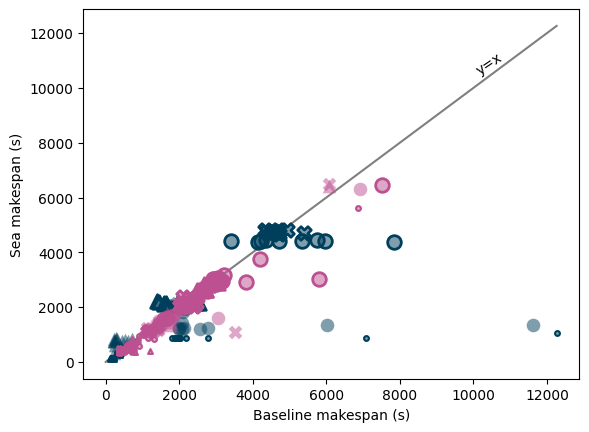

In [22]:
feature_scatter(df_flush, zoom=False, fn='../figures/beluga_withflush_nozoom_updated.pdf')

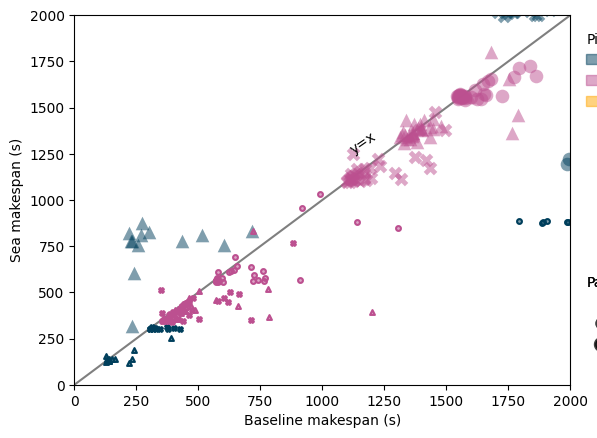

In [35]:
feature_scatter(df_flush, zoom=True, fn='../figures/beluga_withflush_zoom_updated.pdf')